In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import os


In [ ]:
directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/Corrected_Data_Official/nesscanResult_removedBadNesdisRecords/BobHall'
dataframes = []
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['station #', 'date', 'pwl']
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])
bhp = bhp[bhp['date'] >= pd.to_datetime('1996-01-01')]
bhp = bhp.reset_index(drop=True)

n = len(bhp)
pwl = bhp['pwl'].values
third_diff = np.full(n, np.nan)

#pass one
for i in range(3, n):
    window = pwl[i-3:i+1]
    if np.isnan(window).any():
        continue
    third_val = window[0] - 3 * window[1] + 3 * window[2] - window[3]
    third_diff[i] = round(third_val, 5)

#+- 6 std removed
clean_vals = third_diff[~np.isnan(third_diff)]
mean_val = clean_vals.mean()
std_val = clean_vals.std()
threshold_upper = mean_val + 6 * std_val
threshold_lower = mean_val - 6 * std_val

#flagging repeated and spike
spike_flag = np.zeros(n, dtype=int)
pwl_cleaned = pwl.copy()

i = 3
while i < n:
    if np.isnan(pwl[i-3:i+1]).any():
        i += 1
        continue

    third_val = pwl[i-3] - 3 * pwl[i-2] + 3 * pwl[i-1] - pwl[i]

    if third_val > threshold_upper or third_val < threshold_lower:
        # Flag spike
        spike_flag[i] = 1
        spike_val = pwl[i]
        pwl_cleaned[i] = np.nan

        # Check for repeated values (exact matches) right after the spike
        for j in range(1, 6):  # check next 5 values max
            if i + j >= n:
                break
            if pwl[i + j] == spike_val:
                spike_flag[i + j] = 1
                pwl_cleaned[i + j] = np.nan
            else:
                break
        i += j  # jump past the last repeated value
    else:
        i += 1

# --- Save Results ---
bhp['third_diff'] = third_diff
bhp['spike_flag'] = spike_flag
bhp['pwl_cleaned'] = pwl_cleaned

print(bhp.head(20))


   station #                date    pwl  third_diff  spike_flag  pwl_cleaned
0        014 1996-01-01 00:00:00  6.800         NaN           0        6.800
1        014 1996-01-01 00:06:00  6.773         NaN           0        6.773
2        014 1996-01-01 00:12:00  6.806         NaN           0        6.806
3        014 1996-01-01 00:18:00  6.833       0.066           0        6.833
4        014 1996-01-01 00:24:00  6.869      -0.015           0        6.869
5        014 1996-01-01 00:30:00  6.818       0.096           0        6.818
6        014 1996-01-01 00:36:00  6.823      -0.143           0        6.823
7        014 1996-01-01 00:42:00  6.834       0.050           0        6.834
8        014 1996-01-01 00:48:00  6.840       0.011           0        6.840
9        014 1996-01-01 00:54:00  6.855      -0.014           0        6.855
10       014 1996-01-01 01:00:00  6.823       0.056           0        6.823
11       014 1996-01-01 01:06:00  6.840      -0.096           0        6.840

In [4]:
bhp[1885430:1885450]

,station #,date,pwl,third_diff,spike_flag,pwl_cleaned
1885430,014,2017-12-07 10:24:00,7.038,-0.101,0,7.038
1885431,014,2017-12-07 10:30:00,7.020,0.084,0,7.020
1885432,014,2017-12-07 10:36:00,7.015,-0.049,0,7.015
1885433,014,2017-12-07 10:42:00,6.983,0.040,0,6.983
1885434,014,2017-12-07 10:48:00,7.012,-0.088,0,7.012
1885435,014,2017-12-07 10:54:00,6.997,0.105,0,6.997
1885436,014,2017-12-07 11:00:00,7.009,-0.071,0,7.009
1885437,014,2017-12-07 11:06:00,13.619,-6.571,1,NaN
1885438,014,2017-12-07 11:12:00,13.620,13.207,1,NaN
1885439,014,2017-12-07 11:18:00,13.620,-6.608,1,NaN


Text(0, 0.5, 'Freq')

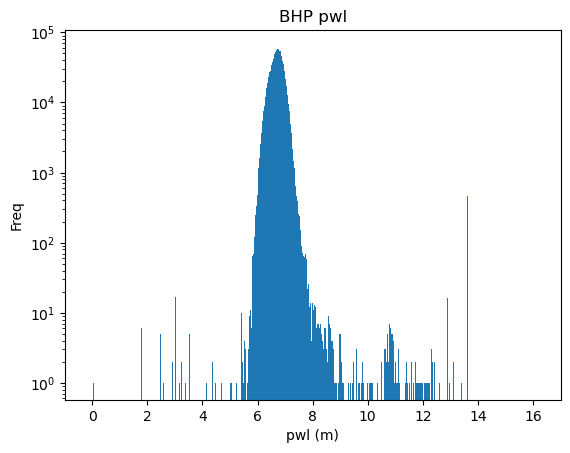

In [9]:
plt.hist(bhp['pwl'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

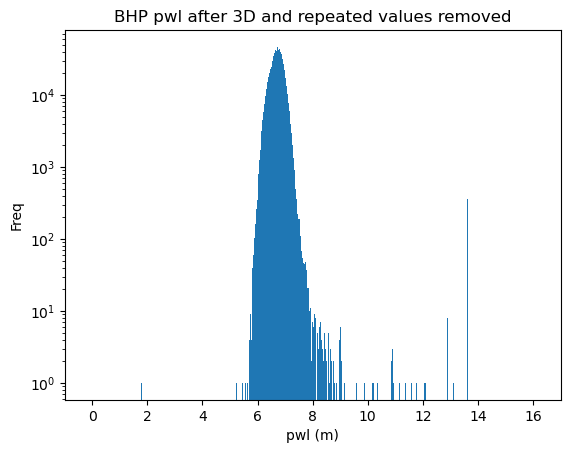

In [7]:
plt.hist(bhp['pwl_cleaned'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl after 3D and repeated values removed')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

In [10]:
bhp['pwl_cleaned'].idxmin()

72994

In [13]:
bhp[72980:73010]

,station #,date,pwl,third_diff,spike_flag,pwl_cleaned
72980,014,1996-11-08 15:12:00,6.583,0.018,0,6.583
72981,014,1996-11-08 15:18:00,6.594,-0.013,0,6.594
72982,014,1996-11-08 15:24:00,6.588,0.033,0,6.588
72983,014,1996-11-08 15:30:00,6.592,-0.027,0,6.592
72984,014,1996-11-08 15:36:00,6.595,0.011,0,6.595
72985,014,1996-11-08 15:42:00,6.593,0.004,0,6.593
72986,014,1996-11-08 15:48:00,2.528,4.058,1,NaN
72987,014,1996-11-08 15:54:00,2.528,-8.128,1,NaN
72988,014,1996-11-08 17:00:00,1.778,4.815,1,NaN
72989,014,1996-11-08 17:06:00,1.778,-1.500,1,NaN


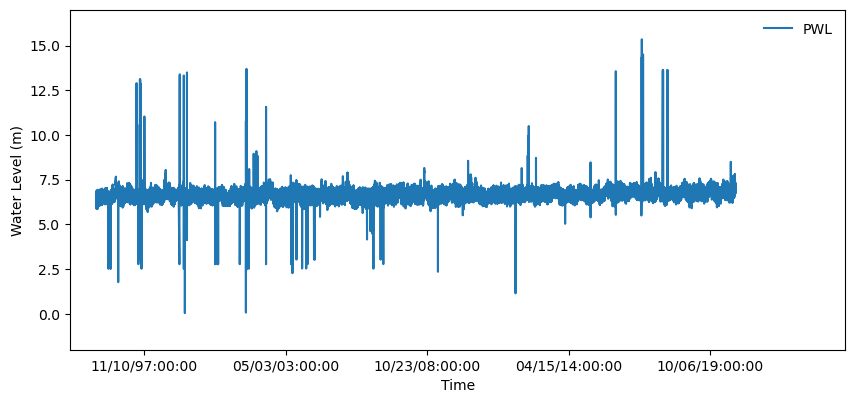

In [18]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2024/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

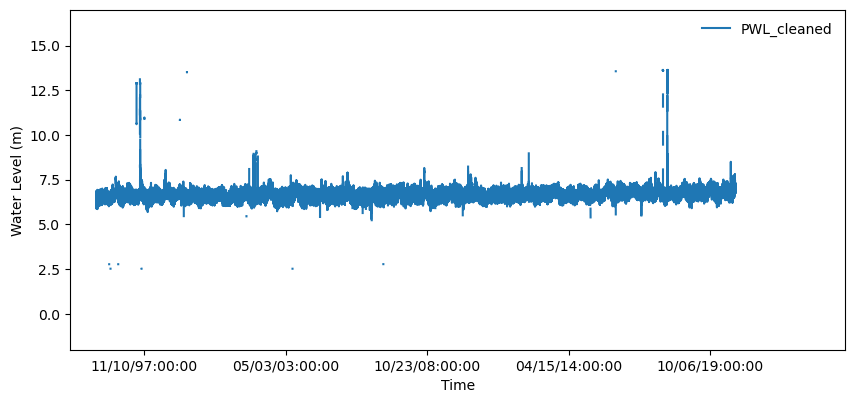

In [17]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2024/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()